In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
#from plotnine import *
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
from PIL import Image
from functools import reduce

def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


In [2]:
os.chdir('F:\\GRETA\\sod_1_cu\\')
csv_path="F:\\GRETA\\sod_1_cu\\batch_out_csv\\"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(csv_path)
                 for file in glob(os.path.join(path, EXT))]
csv_names=pd.DataFrame(all_csv_files)
csv_names.columns = ['csv_text_id']

In [16]:
out = 'F:\\GRETA\\sod_1_cu\\results_and_collated_data\\'

In [17]:
len(all_csv_files)

5400

In [18]:
#need reference fro genotype and treatment etc
ref_df_batch_1=pd.read_csv('sod_ref_master_0_to_100.csv')
ref_df_batch_2=pd.read_csv('sod_ref_master_100_to_200.csv')
ref_df_batch_3a=pd.read_csv('sod_ref_master_200_to_258.csv')
ref_df_batch_3b=pd.read_csv('sod_ref_master_259_to_300.csv')

ref_df=(pd.concat([ref_df_batch_1, ref_df_batch_2]))

ref_df=ref_df.assign(ID=ref_df['IMAGE_ID'].str.extract('(.*)_Tiff_format'))
ref_df[0:5]


,Directonary,IMAGE_ID,min_thresh,max_thresh,first_slice,last_slice,Genptype,Treatment,Width (Pixels),With (um),Height (Pixels),Height (um),C dim,Z dim,T dim,X_pix,Y_pix,Unnamed: 17,ID
0,R:\PRJ-SOD1_AI\cuatsm_treatment_sod_1_analysis...,MS77_SN_Z1_1_GS_Tiff_format,551,698,5,27,SOCK,SSV,13680,1573.20,11400,1311.00,4,41,1,0.115,0.115,0.5,MS77_SN_Z1_1_GS
1,R:\PRJ-SOD1_AI\cuatsm_treatment_sod_1_analysis...,MS77_SN_Z1_2_GS_Tiff_format,537,698,2,27,SOCK,SSV,13680,1573.20,11400,1311.00,4,41,1,0.115,0.115,0.5,MS77_SN_Z1_2_GS
2,R:\PRJ-SOD1_AI\cuatsm_treatment_sod_1_analysis...,MS77_SN_Z3_1_GS_Tiff_format,549,698,1,25,SOCK,SSV,12840,1476.60,11520,1324.80,4,41,1,0.115,0.115,0.5,MS77_SN_Z3_1_GS
3,R:\PRJ-SOD1_AI\cuatsm_treatment_sod_1_analysis...,MS77_SN_Z5_1_GS_Tiff_format,606,698,3,24,SOCK,SSV,11364,1306.86,11982,1377.93,4,41,1,0.115,0.115,0.5,MS77_SN_Z5_1_GS
4,R:\PRJ-SOD1_AI\cuatsm_treatment_sod_1_analysis...,MS77_SN_Z5_2_GS_Tiff_format,539,698,3,27,SOCK,SSV,11364,1306.86,11982,1377.93,4,41,1,0.115,0.115,0.5,MS77_SN_Z5_2_GS


In [20]:
# mask_volume
mask_data_string=str("MASK_Volume")
mask_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(mask_data_string)]

mask_df = []

for index, row in mask_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    mask_df.append(df_i)
    
mask_df = pd.concat(mask_df)
mask_df = mask_df[["ID", "MASK_Volume_Voxel_Resolved"]]
np.shape(mask_df)

(300, 2)

In [ ]:
#Void_Volume
void_data_string=str("Void_Volume")
remove_data_string=str("Protein_in_Void_Volume")
void_data_csvs_1=csv_names[csv_names['csv_text_id'].str.contains(void_data_string)]
void_data_csvs=void_data_csvs_1[~void_data_csvs_1['csv_text_id'].str.contains(remove_data_string)] 

void_df = []

for index, row in void_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    void_df.append(df_i)
    
void_df = pd.concat(void_df)
void_df = void_df[["ID", "Void_Volume_Voxel_Resolved"]]
void_df[0:5]

In [ ]:
# OUTLINE_volume
outline_data_string=str("OUTLINE_Volume")
outline_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(outline_data_string)]

outline_df = []

for index, row in outline_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    outline_df .append(df_i)
    
outline_df  = pd.concat(outline_df )
outline_df = outline_df[["ID", "OUTLINE_Volume_Voxel_Resolved"]]
outline_df[0:5]

### GET ALL THE CELL COMBOS
###### 1) normal cell in neuron outline
###### 2) normal cell outside neuron outline
###### 3) glial cell in neuron outline
###### 4) glial cell outside neuron outline

In [81]:
# 1) normal cell in neuron outline
# Cell_Volume - need to do sums and counts here
#this was dumb should have called them normal cells

cell_data_string=str("Cell_Volume")
gcell_data_string=str("g_Cell_Volume")
cell_data_csvs_1=csv_names[csv_names['csv_text_id'].str.contains(cell_data_string)]
cell_data_csvs=cell_data_csvs_1[~cell_data_csvs_1['csv_text_id'].str.contains(gcell_data_string)] 
cell_df = []

for index, row in cell_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    cell_df .append(df_i)
    
cell_df  = pd.concat(cell_df )
cell_df = cell_df[["ID", "Cell_Label", "normal_Cell_Volume_Voxel_Resolved"]]
cell_df = cell_df.groupby(['ID'], as_index=False).agg(total_cell_volume_normal_cell_in_neuron_outline=('normal_Cell_Volume_Voxel_Resolved','sum'), 
                                            cell_count_normal_cell_in_neuron_outline= ('ID','count'),
                                            mean_cell_size_normal_cell_in_neuron_outline=('normal_Cell_Volume_Voxel_Resolved','mean'))
normal_cell_in_neuron_outline=cell_df
np.shape(normal_cell_in_neuron_outline)
normal_cell_in_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\1547418112.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cell_df  = pd.concat(cell_df )


,ID,total_cell_volume_normal_cell_in_neuron_outline,cell_count_normal_cell_in_neuron_outline,mean_cell_size_normal_cell_in_neuron_outline
0,MS100_SN_Z11_1_GS,237402.9272,71,3343.703200
1,MS100_SN_Z13_1_GS,370560.5854,98,3781.230463
2,MS100_SN_Z15_1_GS,256342.8200,73,3511.545479
3,MS100_SN_Z17_1_GS,107984.1352,26,4153.235969
4,MS100_SN_Z17_2_GS,265329.3662,82,3235.723978


In [82]:
# 2) normal cell outside neuron outline
# Cell_Volume - need to do sums and counts here
#this was dumb should have called them normal cells

cell_data_string=str("cells_masked_outside")
gcell_data_string=str("g_Cell_Volume")
cell_data_csvs_1=csv_names[csv_names['csv_text_id'].str.contains(cell_data_string)]
cell_data_csvs=cell_data_csvs_1[~cell_data_csvs_1['csv_text_id'].str.contains(gcell_data_string)] 
cell_df = []

for index, row in cell_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    cell_df .append(df_i)
    
cell_df  = pd.concat(cell_df )
cell_df = cell_df[["ID", "Cell_Label", "cells_masked_outside_Volume_Voxel_Resolved"]]
cell_df = cell_df.groupby(['ID'], as_index=False).agg(total_cell_volume_normal_cell_outside_neuron_outline=('cells_masked_outside_Volume_Voxel_Resolved','sum'), 
                                            cell_count_normal_cell_outside_neuron_outline= ('ID','count'),
                                            mean_cell_size_normal_cell_outside_neuron_outline=('cells_masked_outside_Volume_Voxel_Resolved','mean'))
normal_cell_outside_neuron_outline=cell_df
np.shape(normal_cell_outside_neuron_outline)
normal_cell_outside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\754940317.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cell_df  = pd.concat(cell_df )


,ID,total_cell_volume_normal_cell_outside_neuron_outline,cell_count_normal_cell_outside_neuron_outline,mean_cell_size_normal_cell_outside_neuron_outline
0,MS100_SN_Z11_1_GS,1741.5738,2,870.78690
1,MS100_SN_Z13_1_GS,8260.8640,4,2065.21600
2,MS100_SN_Z15_1_GS,1780.8256,2,890.41280
3,MS100_SN_Z17_2_GS,4313.6776,5,862.73552
4,MS100_SN_Z17_2_controlGS,4313.6776,5,862.73552


In [84]:
# 3) glial cell in neuron outline
# Cell_Volume - need to do sums and counts here
#this was dumb should have called them normal cells

gcell_data_string=str("gilal_cells_outline")
cell_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(gcell_data_string)]
cell_df = []

for index, row in cell_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    cell_df .append(df_i)
    
cell_df  = pd.concat(cell_df )
glial_cell_outside_neuron_outline=cell_df
np.shape(glial_cell_outside_neuron_outline)
glial_cell_outside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\2018369350.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cell_df  = pd.concat(cell_df )


,Unnamed: 0,Cell_Label,Cell_Area_Pixels,gilal_cells_outline_Volume_Voxel_Resolved,ID,filename
0,0,255,3259103.0,344813.0974,MS100_SN_Z11_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z11_1...
0,0,255,600705.0,63554.5890,MS100_SN_Z13_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z13_1...
0,0,255,301934.0,31944.6172,MS100_SN_Z15_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z15_1...
0,0,255,29749.0,3147.4442,MS100_SN_Z17_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z17_1...
0,0,255,103741.0,10975.7978,MS100_SN_Z17_2_controlGS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z17_2...


In [85]:
# 4) glial cell in neuron outline
# Cell_Volume - need to do sums and counts here
#this was dumb should have called them normal cells

gcell_data_string=str("gilal_cells_outside")
cell_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(gcell_data_string)]
cell_df = []

for index, row in cell_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    cell_df .append(df_i)
    
cell_df  = pd.concat(cell_df )
glial_cell_outside_neuron_outline=cell_df
np.shape(glial_cell_outside_neuron_outline)
glial_cell_outside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\327511369.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cell_df  = pd.concat(cell_df )


,Unnamed: 0,Cell_Label,Cell_Area_Pixels,gilal_cells_outside_Volume_Voxel_Resolved,ID,filename
0,0,255,13365182.0,1.414036e+06,MS100_SN_Z11_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z11_1...
0,0,255,10625935.0,1.124224e+06,MS100_SN_Z13_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z13_1...
0,0,255,7866967.0,8.323251e+05,MS100_SN_Z15_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z15_1...
0,0,255,1039095.0,1.099363e+05,MS100_SN_Z17_1_GS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z17_1...
0,0,255,6025302.0,6.374770e+05,MS100_SN_Z17_2_controlGS,F:\GRETA\sod_1_cu\batch_out_csv\MS100_SN_Z17_2...


### GET ALL THE protein COMBOS
###### 1) sod1 in normal cell in neuron outline
###### 2) sod1 in  normal cell outside neuron outline
###### 3) sod1 in  glial cell in neuron outline
###### 4) sod1 in  glial cell outside neuron outline
###### 5) sod1 in void in neuron outline
###### 6) sod1 in  in void outside neuron outline

In [89]:
###### 1) sod1 in normal cell in neuron outline
protein_in_X_data_string=str("Protein_in_cell")
protein_in_X_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(protein_in_X_data_string)]

protein_in_X_df = []

for index, row in protein_in_X_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    protein_in_X_df .append(df_i)
    
protein_in_X_df  = pd.concat(protein_in_X_df )
protein_in_X_df = protein_in_X_df[["ID", "Protein_Label", "normal_cell_Proten_Volume_Voxel_Resolved"]]
protein_in_X_df = protein_in_X_df.groupby(['ID'], as_index=False).agg(total_protein_volume_sod1_in_normal_cell_in_neuron_outline=('normal_cell_Proten_Volume_Voxel_Resolved','sum'), 
                                            protein_count_sod1_in_normal_cell_in_neuron_outline= ('ID','count'),
                                            max_sod_1_agg_size_sod1_in_normal_cell_in_neuron_outline=('normal_cell_Proten_Volume_Voxel_Resolved','max'),
                                            min_sod_1_agg_size_sod1_in_normal_cell_in_neuron_outline=('normal_cell_Proten_Volume_Voxel_Resolved','min'),
                                            mean_sod_1_agg_size_sod1_in_normal_cell_in_neuron_outline=('normal_cell_Proten_Volume_Voxel_Resolved','mean'))
    

sod1_in_normal_cell_in_neuron_outline=protein_in_X_df
sod1_in_normal_cell_in_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\304836057.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_in_X_df  = pd.concat(protein_in_X_df )


,ID,total_protein_volume_sod1_in_normal_cell_in_neuron_outline,protein_count_sod1_in_normal_cell_in_neuron_outline,max_sod_1_agg_size_sod1_in_normal_cell_in_neuron_outline,min_sod_1_agg_size_sod1_in_normal_cell_in_neuron_outline,mean_sod_1_agg_size_sod1_in_normal_cell_in_neuron_outline
0,MS100_SN_Z11_1_GS,35.2314,60,7.6176,0.1058,0.587190
1,MS100_SN_Z13_1_GS,119.3424,198,13.7540,0.1058,0.602739
2,MS100_SN_Z15_1_GS,78.3978,123,5.6074,0.1058,0.637380
3,MS100_SN_Z17_1_GS,11.2148,25,3.2798,0.1058,0.448592
4,MS100_SN_Z17_2_GS,88.2372,162,10.5800,0.1058,0.544674


In [90]:
###### 2) sod1 in  normal cell outside neuron outline
protein_in_X_data_string=str("protein_in_cell_outside")
protein_in_X_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(protein_in_X_data_string)]

protein_in_X_df = []

for index, row in protein_in_X_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    protein_in_X_df .append(df_i)
    
protein_in_X_df  = pd.concat(protein_in_X_df )
protein_in_X_df = protein_in_X_df[["ID", "Protein_Label", "protein_in_cell_outside_Proten_Volume_Voxel_Resolved"]]
protein_in_X_df = protein_in_X_df.groupby(['ID'], as_index=False).agg(total_protein_volume_sod1_in_normal_cell_outside_neuron_outline=('protein_in_cell_outside_Proten_Volume_Voxel_Resolved','sum'), 
                                            protein_count_sod1_in_normal_cell_outside_neuron_outline= ('ID','count'),
                                            max_sod_1_agg_size_sod1_in_normal_cell_outside_neuron_outline=('protein_in_cell_outside_Proten_Volume_Voxel_Resolved','max'),
                                            min_sod_1_agg_size_sod1_in_normal_cell_outside_neuron_outline=('protein_in_cell_outside_Proten_Volume_Voxel_Resolved','min'),
                                            mean_sod_1_agg_size_sod1_in_normal_cell_outside_neuron_outline=('protein_in_cell_outside_Proten_Volume_Voxel_Resolved','mean'))
    

sod1_in_normal_cell_outside_neuron_outline=protein_in_X_df
sod1_in_normal_cell_outside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\2700343811.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_in_X_df  = pd.concat(protein_in_X_df )


,ID,total_protein_volume_sod1_in_normal_cell_outside_neuron_outline,protein_count_sod1_in_normal_cell_outside_neuron_outline,max_sod_1_agg_size_sod1_in_normal_cell_outside_neuron_outline,min_sod_1_agg_size_sod1_in_normal_cell_outside_neuron_outline,mean_sod_1_agg_size_sod1_in_normal_cell_outside_neuron_outline
0,MS100_SN_Z17_2_GS,2.2218,8,1.1638,0.1058,0.277725
1,MS100_SN_Z17_2_controlGS,2.2218,8,1.1638,0.1058,0.277725
2,MS100_SN_Z3_2_GS,6.9828,4,4.7610,0.2116,1.745700
3,MS100_SN_Z5_1_GS,7.3002,10,1.9044,0.1058,0.730020
4,MS102_SN_Z15_1_GS,0.3174,1,0.3174,0.3174,0.317400


In [91]:
###### 3) sod1 in  glial cell in neuron outline
protein_in_X_data_string=str("protein_in_g_cell_inside")
protein_in_X_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(protein_in_X_data_string)]

protein_in_X_df = []

for index, row in protein_in_X_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    protein_in_X_df .append(df_i)
    
protein_in_X_df  = pd.concat(protein_in_X_df )
protein_in_X_df = protein_in_X_df[["ID", "Protein_Label", "protein_in_g_cell_inside_Proten_Volume_Voxel_Resolved"]]
protein_in_X_df = protein_in_X_df.groupby(['ID'], as_index=False).agg(total_protein_volume_sod1_in_glial_cell_inside_neuron_outline=('protein_in_g_cell_inside_Proten_Volume_Voxel_Resolved','sum'), 
                                            protein_count_sod1_in_glial_cell_inside_neuron_outline= ('ID','count'),
                                            max_sod_1_agg_size_sod1_in_glial_cell_inside_neuron_outline=('protein_in_g_cell_inside_Proten_Volume_Voxel_Resolved','max'),
                                            min_sod_1_agg_size_sod1_in_glial_cell_inside_neuron_outline=('protein_in_g_cell_inside_Proten_Volume_Voxel_Resolved','min'),
                                            mean_sod_1_agg_size_sod1_in_glial_cell_inside_neuron_outline=('protein_in_g_cell_inside_Proten_Volume_Voxel_Resolved','mean'))
    

sod1_in_glial_cell_inside_neuron_outline=protein_in_X_df
sod1_in_glial_cell_inside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\1558371097.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_in_X_df  = pd.concat(protein_in_X_df )


,ID,total_protein_volume_sod1_in_glial_cell_inside_neuron_outline,protein_count_sod1_in_glial_cell_inside_neuron_outline,max_sod_1_agg_size_sod1_in_glial_cell_inside_neuron_outline,min_sod_1_agg_size_sod1_in_glial_cell_inside_neuron_outline,mean_sod_1_agg_size_sod1_in_glial_cell_inside_neuron_outline
0,MS100_SN_Z11_1_GS,83.5820,125,11.2148,0.1058,0.668656
1,MS100_SN_Z13_1_GS,58.2958,51,14.4946,0.1058,1.143055
2,MS100_SN_Z15_1_GS,20.3136,17,10.6858,0.1058,1.194918
3,MS100_SN_Z17_2_GS,28.3544,34,9.2046,0.1058,0.833953
4,MS100_SN_Z17_2_controlGS,28.3544,34,9.2046,0.1058,0.833953


In [92]:
###### 4) sod1 in  glial cell outside neuron outline
protein_in_X_data_string=str("protein_in_g_cell_outside")
protein_in_X_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(protein_in_X_data_string)]

protein_in_X_df = []

for index, row in protein_in_X_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    protein_in_X_df .append(df_i)
    
protein_in_X_df  = pd.concat(protein_in_X_df )
protein_in_X_df = protein_in_X_df[["ID", "Protein_Label", "protein_in_g_cell_outside_Proten_Volume_Voxel_Resolved"]]
protein_in_X_df = protein_in_X_df.groupby(['ID'], as_index=False).agg(total_protein_volume_sod1_in_glial_cell_outside_neuron_outline=('protein_in_g_cell_outside_Proten_Volume_Voxel_Resolved','sum'), 
                                            protein_count_sod1_in_glial_cell_outside_neuron_outline= ('ID','count'),
                                            max_sod_1_agg_size_sod1_in_glial_cell_outside_neuron_outline=('protein_in_g_cell_outside_Proten_Volume_Voxel_Resolved','max'),
                                            min_sod_1_agg_size_sod1_in_glial_cell_outside_neuron_outline=('protein_in_g_cell_outside_Proten_Volume_Voxel_Resolved','min'),
                                            mean_sod_1_agg_size_sod1_in_glial_cell_outside_neuron_outline=('protein_in_g_cell_outside_Proten_Volume_Voxel_Resolved','mean'))
    

sod1_in_glial_cell_outside_neuron_outline=protein_in_X_df
sod1_in_glial_cell_outside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\1146875423.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_in_X_df  = pd.concat(protein_in_X_df )


,ID,total_protein_volume_sod1_in_glial_cell_outside_neuron_outline,protein_count_sod1_in_glial_cell_outside_neuron_outline,max_sod_1_agg_size_sod1_in_glial_cell_outside_neuron_outline,min_sod_1_agg_size_sod1_in_glial_cell_outside_neuron_outline,mean_sod_1_agg_size_sod1_in_glial_cell_outside_neuron_outline
0,MS100_SN_Z11_1_GS,322.0552,399,28.1428,0.1058,0.807156
1,MS100_SN_Z13_1_GS,88.5546,124,6.6654,0.1058,0.714150
2,MS100_SN_Z15_1_GS,66.7598,130,10.5800,0.1058,0.513537
3,MS100_SN_Z17_1_GS,2.8566,9,1.2696,0.1058,0.317400
4,MS100_SN_Z17_2_GS,90.7764,141,8.9930,0.1058,0.643804


In [93]:
###### 5) sod1 in void in neuron outline
protein_in_X_data_string=str("protein_in_void_inside")
protein_in_X_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(protein_in_X_data_string)]

protein_in_X_df = []

for index, row in protein_in_X_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    protein_in_X_df .append(df_i)
    
protein_in_X_df  = pd.concat(protein_in_X_df )
protein_in_X_df = protein_in_X_df[["ID", "Protein_Label", "protein_in_void_inside_Proten_Volume_Voxel_Resolved"]]
protein_in_X_df = protein_in_X_df.groupby(['ID'], as_index=False).agg(total_protein_volume_sod1_in_void_inside_neuron_outline=('protein_in_void_inside_Proten_Volume_Voxel_Resolved','sum'), 
                                            protein_count_sod1_in_void_inside_neuron_outline= ('ID','count'),
                                            max_sod_1_agg_size_sod1_in_void_inside_neuron_outline=('protein_in_void_inside_Proten_Volume_Voxel_Resolved','max'),
                                            min_sod_1_agg_size_sod1_in_void_inside_neuron_outline=('protein_in_void_inside_Proten_Volume_Voxel_Resolved','min'),
                                            mean_sod_1_agg_size_sod1_in_void_inside_neuron_outline=('protein_in_void_inside_Proten_Volume_Voxel_Resolved','mean'))
    

sod1_in_void_inside_neuron_outline=protein_in_X_df
sod1_in_void_inside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\333918211.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_in_X_df  = pd.concat(protein_in_X_df )


,ID,total_protein_volume_sod1_in_void_inside_neuron_outline,protein_count_sod1_in_void_inside_neuron_outline,max_sod_1_agg_size_sod1_in_void_inside_neuron_outline,min_sod_1_agg_size_sod1_in_void_inside_neuron_outline,mean_sod_1_agg_size_sod1_in_void_inside_neuron_outline
0,MS100_SN_Z11_1_GS,530.7986,653,21.2658,0.1058,0.812862
1,MS100_SN_Z13_1_GS,1804.1016,1695,72.2614,0.1058,1.064367
2,MS100_SN_Z15_1_GS,1046.3620,1405,42.3200,0.1058,0.744742
3,MS100_SN_Z17_1_GS,186.6312,255,12.2728,0.1058,0.731887
4,MS100_SN_Z17_2_GS,1512.6226,2203,89.5068,0.1058,0.686619


In [98]:
###### 6) sod1 in  in void outside neuron outline
protein_in_X_data_string=str("protein_in_void_outside")
protein_in_X_data_csvs=csv_names[csv_names['csv_text_id'].str.contains(protein_in_X_data_string)]

protein_in_X_df = []

for index, row in protein_in_X_data_csvs.iterrows():
    df_i = pd.read_csv(row['csv_text_id'])
    df_i['filename'] = str(row['csv_text_id'])
    #df_i["IMAGE_ID"] = find_between( str(df_i["filename"].iloc[0]), "batch_1\\", "MASK_Volume.csv" )
    protein_in_X_df .append(df_i)
    
protein_in_X_df  = pd.concat(protein_in_X_df )
protein_in_X_df = protein_in_X_df[["ID", "Protein_Label", "protein_in_void_outside_Proten_Volume_Voxel_Resolved"]]
protein_in_X_df = protein_in_X_df.groupby(['ID'], as_index=False).agg(total_protein_volume_sod1_in_void_outside_neuron_outline=('protein_in_void_outside_Proten_Volume_Voxel_Resolved','sum'), 
                                            protein_count_sod1_in_void_outside_neuron_outline= ('ID','count'),
                                            max_sod_1_agg_size_sod1_in_void_outside_neuron_outline=('protein_in_void_outside_Proten_Volume_Voxel_Resolved','max'),
                                            min_sod_1_agg_size_sod1_in_void_outside_neuron_outline=('protein_in_void_outside_Proten_Volume_Voxel_Resolved','min'),
                                            mean_sod_1_agg_size_sod1_in_void_outside_neuron_outline=('protein_in_void_outside_Proten_Volume_Voxel_Resolved','mean'))
    

sod1_in_void_outside_neuron_outline=protein_in_X_df
sod1_in_void_outside_neuron_outline[0:5]

C:\Users\richa\AppData\Local\Temp\ipykernel_6920\820586550.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_in_X_df  = pd.concat(protein_in_X_df )


,ID,total_protein_volume_sod1_in_void_outside_neuron_outline,protein_count_sod1_in_void_outside_neuron_outline,max_sod_1_agg_size_sod1_in_void_outside_neuron_outline,min_sod_1_agg_size_sod1_in_void_outside_neuron_outline,mean_sod_1_agg_size_sod1_in_void_outside_neuron_outline
0,MS100_SN_Z11_1_GS,994.3084,1209,44.4360,0.1058,0.822422
1,MS100_SN_Z13_1_GS,194.6720,264,16.1874,0.1058,0.737394
2,MS100_SN_Z15_1_GS,146.4272,261,10.7916,0.1058,0.561024
3,MS100_SN_Z17_1_GS,16.7164,51,1.6928,0.1058,0.327773
4,MS100_SN_Z17_2_GS,1896.5708,1873,139.9734,0.1058,1.012585


In [ ]:
#need to merge the csvs
data_frames = [ref_df,protein_in_void_volume_df, protein_in_gcell_volume_df, protein_in_cell_volume_df,cell_df,
              gcell_df,outline_df,mask_df,void_df]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['ID'],
                                            how='outer'), data_frames)

In [14]:
#% sod_1
df_merged["sod1_in_normal_cells_perc"]=(df_merged["normal_cell_Proten_Volume_Voxel_Resolved"]/df_merged["total_cell_volume"])*100
df_merged["sod1_in_void_perc"]=(df_merged["Void_Proten_Volume_Voxel_Resolved"]/df_merged["Void_Volume_Voxel_Resolved"])*100
df_merged["sod1_in_gcells_perc"]=(df_merged["gcell_Proten_Volume_Voxel_Resolved"]/df_merged["g_Cell_Volume_Voxel_Resolved"])*100

In [15]:
df_merged["sod1_in_void_perc"]

0      0.013910
1      0.020411
2      0.016658
3      0.011684
4      0.034497
         ...   
195    0.016041
196    0.778822
197    0.014216
198    0.008897
199    0.064076
Name: sod1_in_void_perc, Length: 200, dtype: float64

In [16]:
#normalise cell counts and volume
df_merged["cell_count_normalised"]=df_merged["cell_count"]/df_merged["OUTLINE_Volume_Voxel_Resolved"]
df_merged["cell_volume_normalised"]=df_merged["total_cell_volume"]/df_merged["OUTLINE_Volume_Voxel_Resolved"]

In [17]:
#WRITE CSV
df_merged.to_csv("F:\\GRETA\\batch_output_csv\\sod_1_cuatsm_summary.csv")

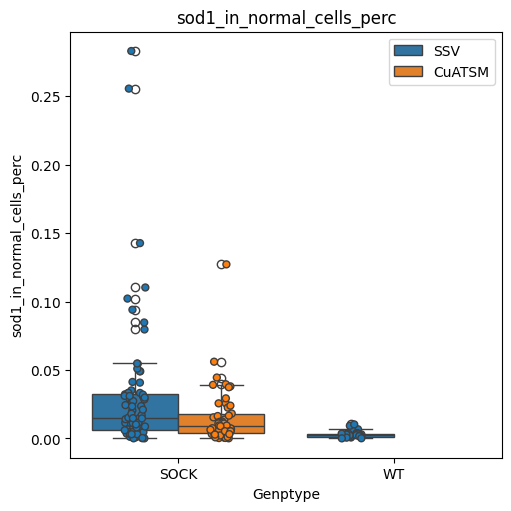

In [18]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.boxplot(data=df_merged, x="Genptype", y="sod1_in_normal_cells_perc", hue="Treatment")
sns.stripplot(x="Genptype", y="sod1_in_normal_cells_perc",  hue="Treatment", data=df_merged, dodge=True,ax=plot, linewidth=1)
plot.set(title='sod1_in_normal_cells_perc');
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

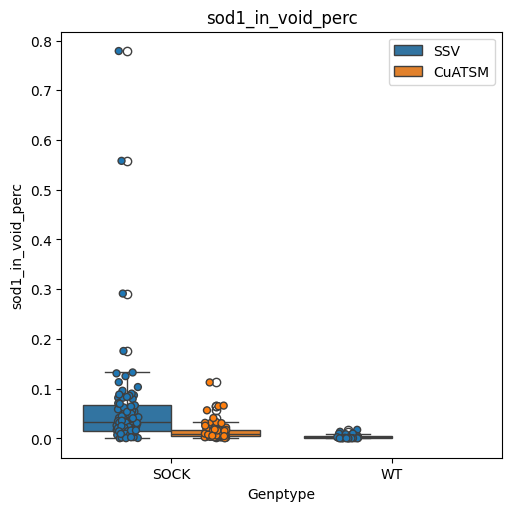

In [19]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.boxplot(data=df_merged, x="Genptype", y="sod1_in_void_perc", hue="Treatment")
sns.stripplot(x="Genptype", y="sod1_in_void_perc",  hue="Treatment", data=df_merged, dodge=True,ax=plot, linewidth=1)
plot.set(title='sod1_in_void_perc');
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

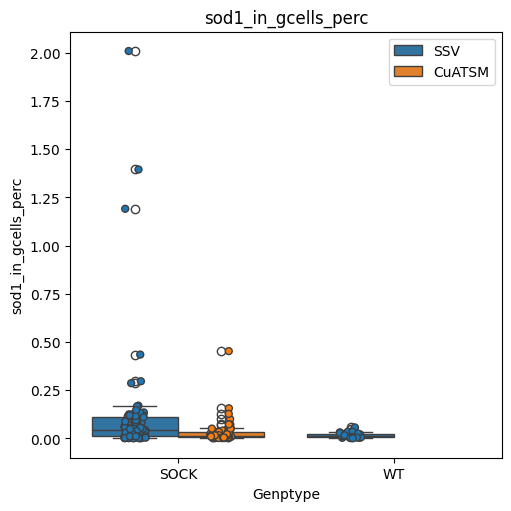

In [20]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.boxplot(data=df_merged, x="Genptype", y="sod1_in_gcells_perc", hue="Treatment")
sns.stripplot(x="Genptype", y="sod1_in_gcells_perc",  hue="Treatment", data=df_merged, dodge=True,ax=plot, linewidth=1)
plot.set(title='sod1_in_gcells_perc');
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

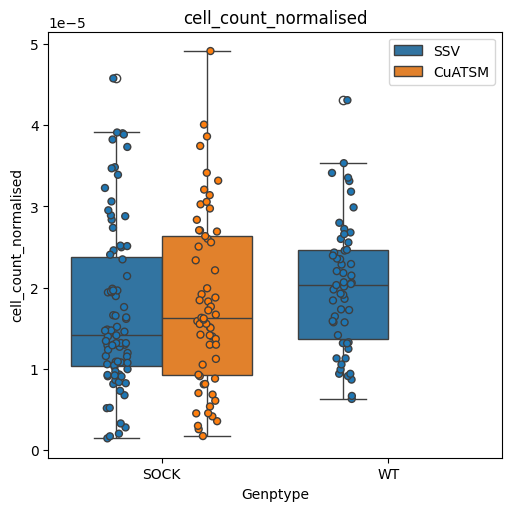

In [21]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.boxplot(data=df_merged, x="Genptype", y="cell_count_normalised", hue="Treatment")
sns.stripplot(x="Genptype", y="cell_count_normalised",  hue="Treatment", data=df_merged, dodge=True,ax=plot, linewidth=1)
plot.set(title='cell_count_normalised');
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

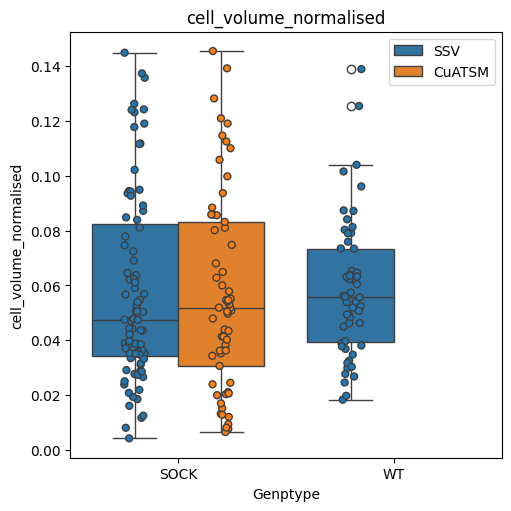

In [22]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.boxplot(data=df_merged, x="Genptype", y="cell_volume_normalised", hue="Treatment")
sns.stripplot(x="Genptype", y="cell_volume_normalised",  hue="Treatment", data=df_merged, dodge=True,ax=plot, linewidth=1)
plot.set(title='cell_volume_normalised');
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

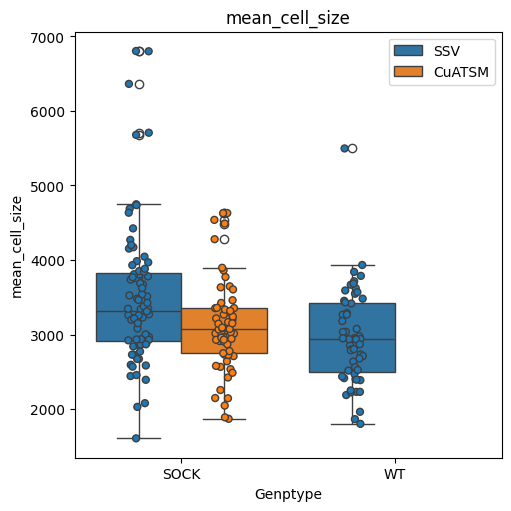

In [23]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.boxplot(data=df_merged, x="Genptype", y="mean_cell_size", hue="Treatment")
sns.stripplot(x="Genptype", y="mean_cell_size",  hue="Treatment", data=df_merged, dodge=True,ax=plot, linewidth=1)
plot.set(title='mean_cell_size');
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

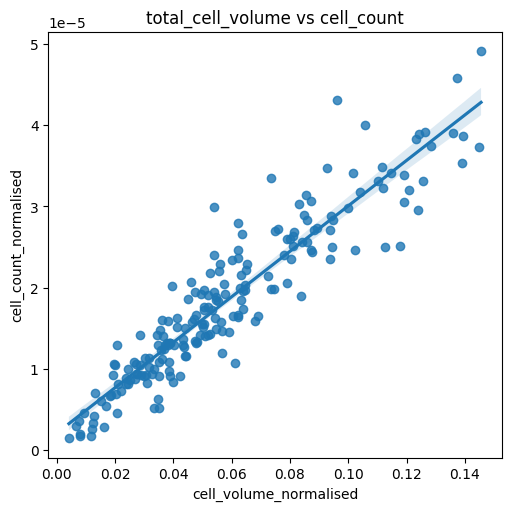

In [24]:
plt.figure(figsize=(5,5), constrained_layout=True)
plot=sns.regplot(data=df_merged, x="cell_volume_normalised", y="cell_count_normalised");
plot.set(title='total_cell_volume vs cell_count');